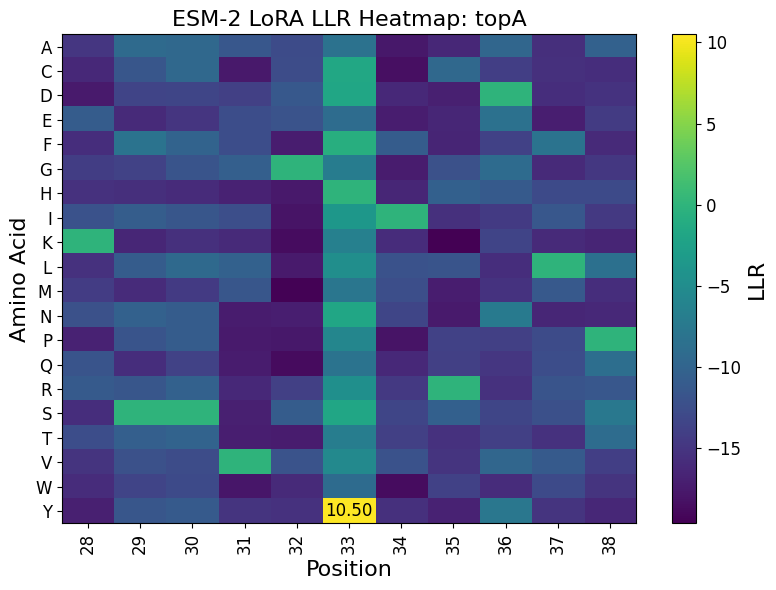

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_centered_heatmap(csv_file, mutated_pos, window_size=5, figsize=(8, 6), cmap="viridis"):
    """
    Load LLR data from CSV, center the heatmap around mutated_pos ± window_size, annotate 
    only the highest LLR cell, and plot with increased font sizes.
    """
    # Load data
    df = pd.read_csv(csv_file, index_col=0)
    df.columns = df.columns.astype(int)
    df = df.sort_index(axis=1)
    
    # Find center window
    cols = df.columns.tolist()
    if mutated_pos not in cols:
        raise ValueError(f"{mutated_pos} not in CSV columns.")
    idx = cols.index(mutated_pos)
    start = max(0, idx - window_size)
    end = min(len(cols), idx + window_size + 1)
    sub_df = df.iloc[:, start:end]
    
    # Compute max LLR cell
    values = sub_df.values
    max_i, max_j = np.unravel_index(np.nanargmax(values), values.shape)
    max_val = values[max_i, max_j]
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(values, aspect='auto', cmap=cmap)
    
    # Annotate only the max cell
    ax.text(max_j, max_i, f"{max_val:.2f}", ha='center', va='center',
             fontsize=12, color='black')
    
    # Labels and ticks
    ax.set_xticks(range(values.shape[1]))
    ax.set_xticklabels(sub_df.columns, rotation=90, fontsize=12)
    ax.set_yticks(range(values.shape[0]))
    ax.set_yticklabels(sub_df.index, fontsize=12)
    ax.set_xlabel("Position", fontsize=16)
    ax.set_ylabel("Amino Acid", fontsize=16)
    ax.set_title(f"ESM-2 LoRA LLR Heatmap: topA", fontsize=16)
    
    # Colorbar
    cbar = plt.colorbar(cax, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label("LLR", fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Usage example (uncomment and update paths):
# plot_centered_heatmap("topA_llr_30-40.csv", mutated_pos=33, window_size=5)

# Example usage:
csv_file = "topA_llr_esm2_finetuned_corrected.csv"  # replace with your CSV path
mutated_pos = 33                 # the mutation position to center
window_size = 5              # number of positions on each side
plot_centered_heatmap(csv_file, mutated_pos, window_size)

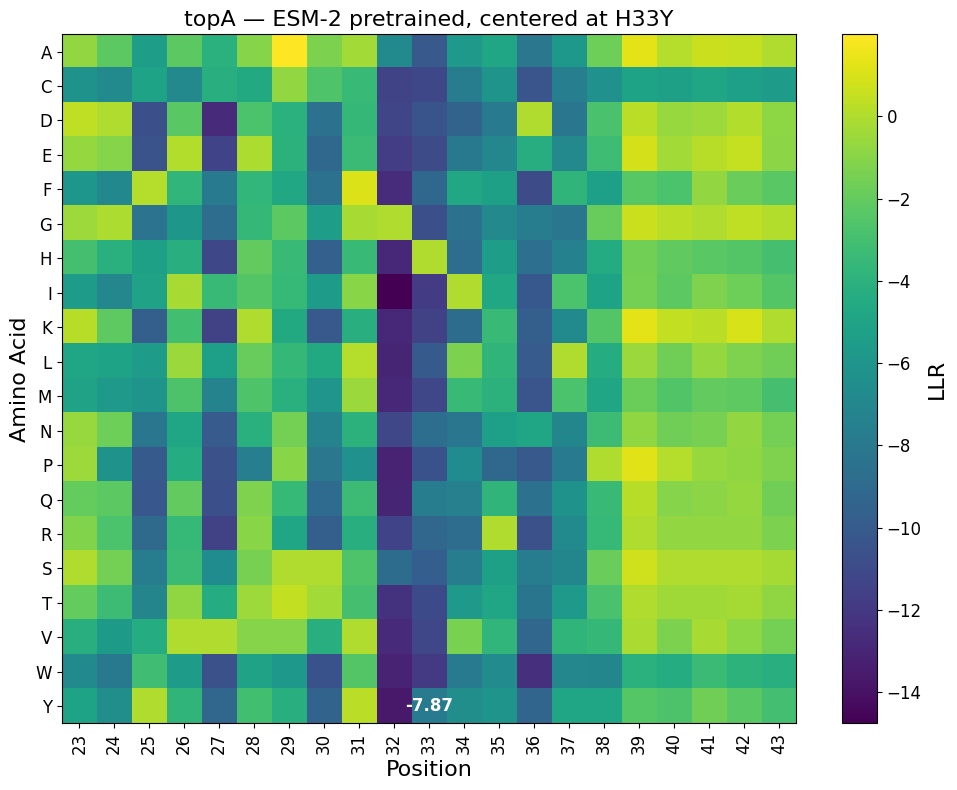

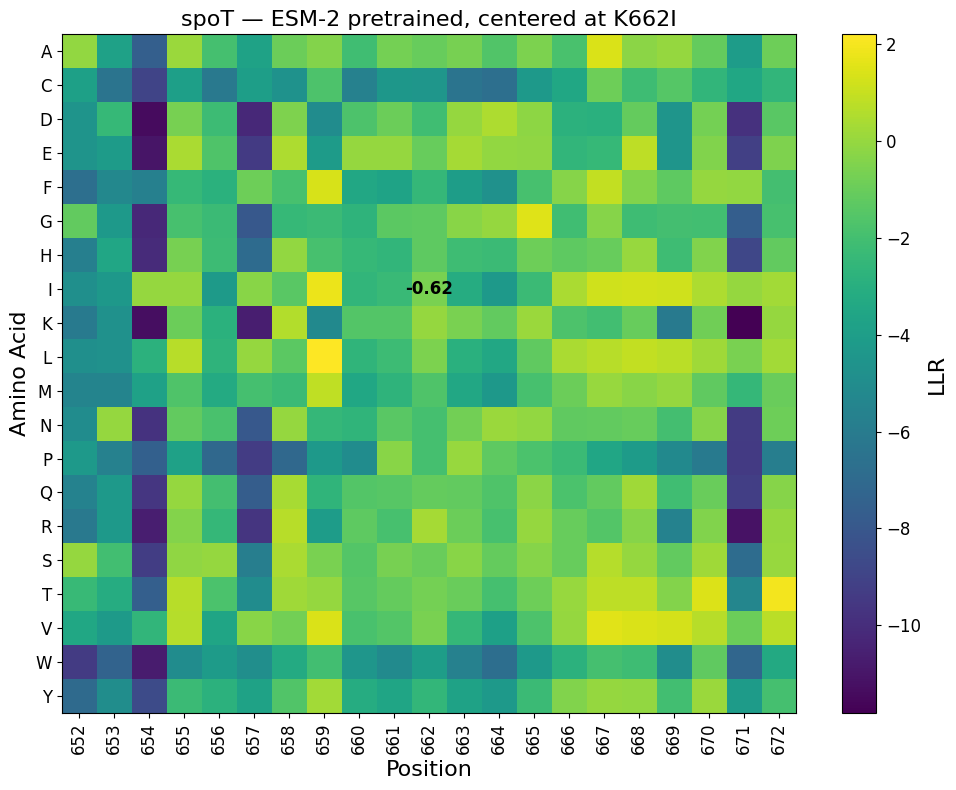

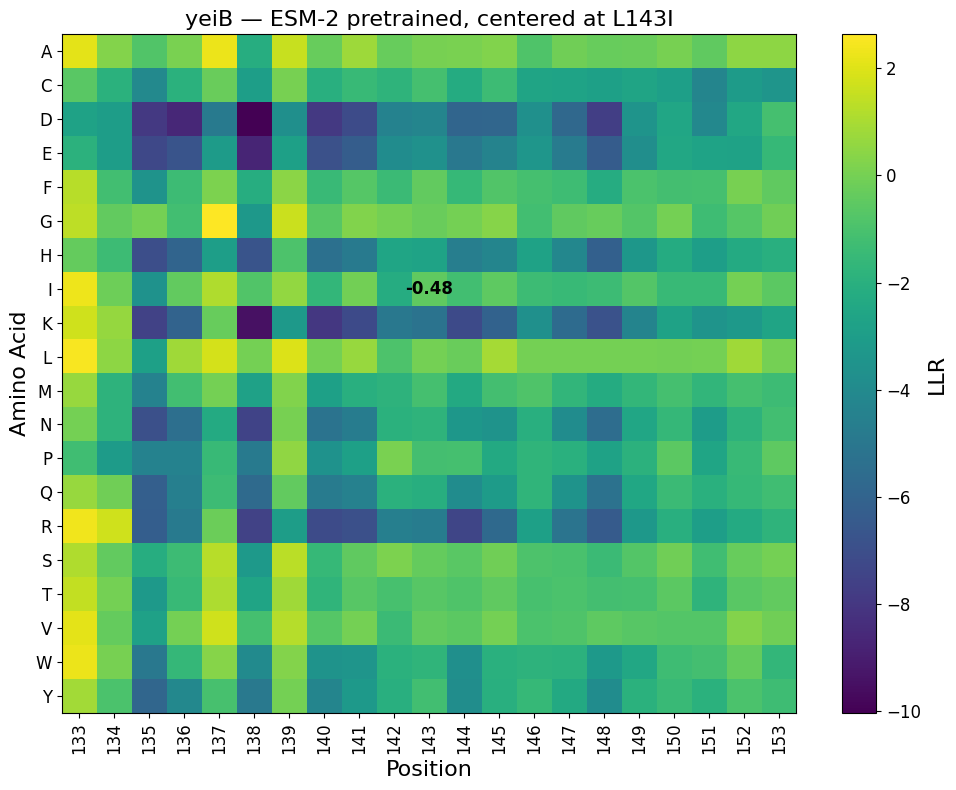

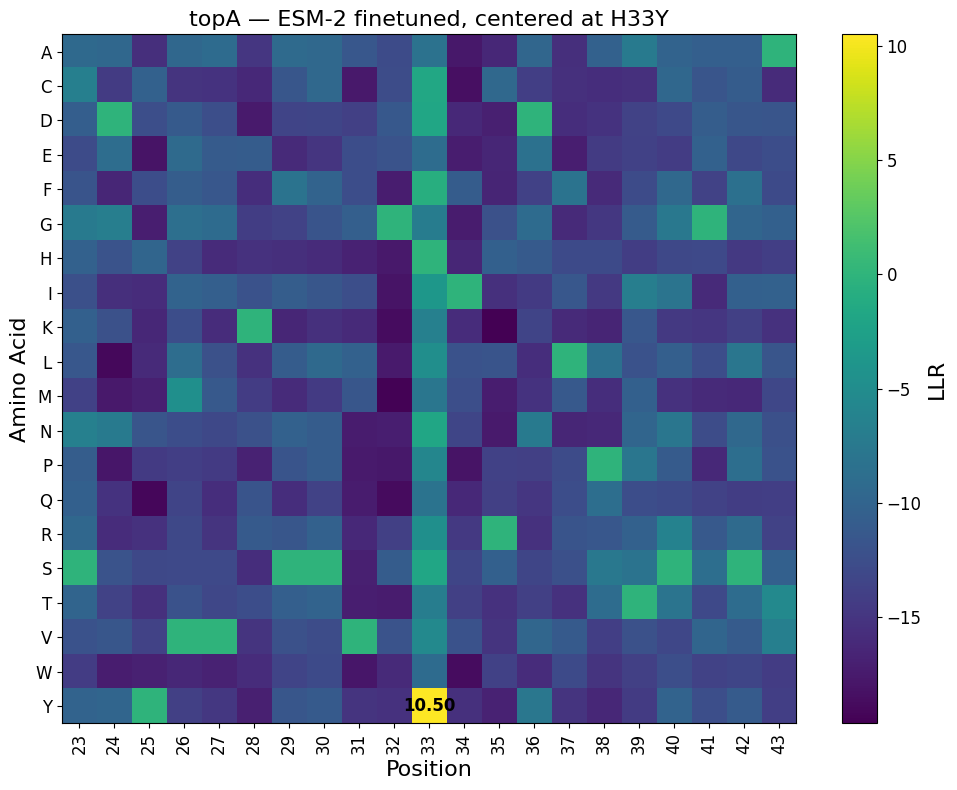

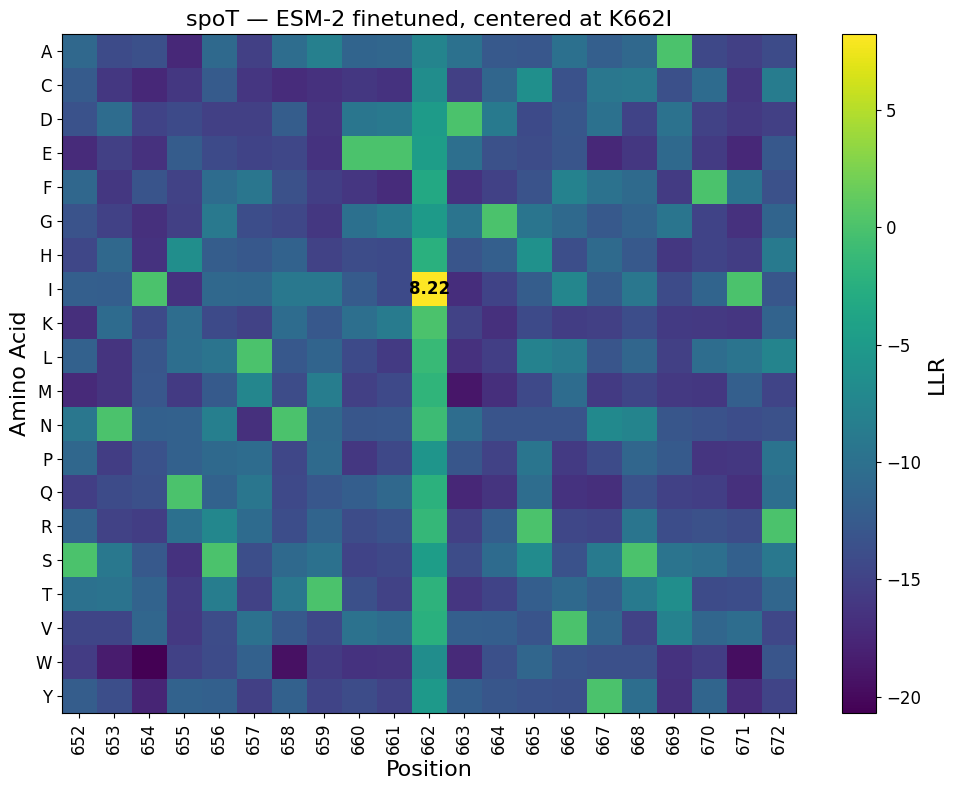

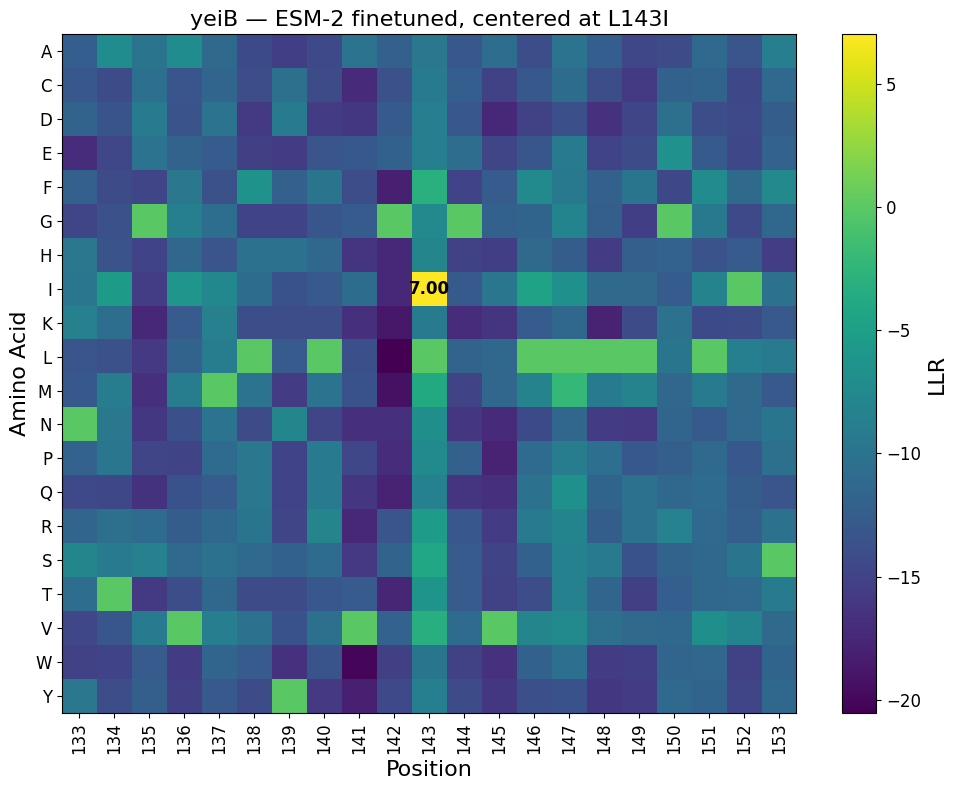

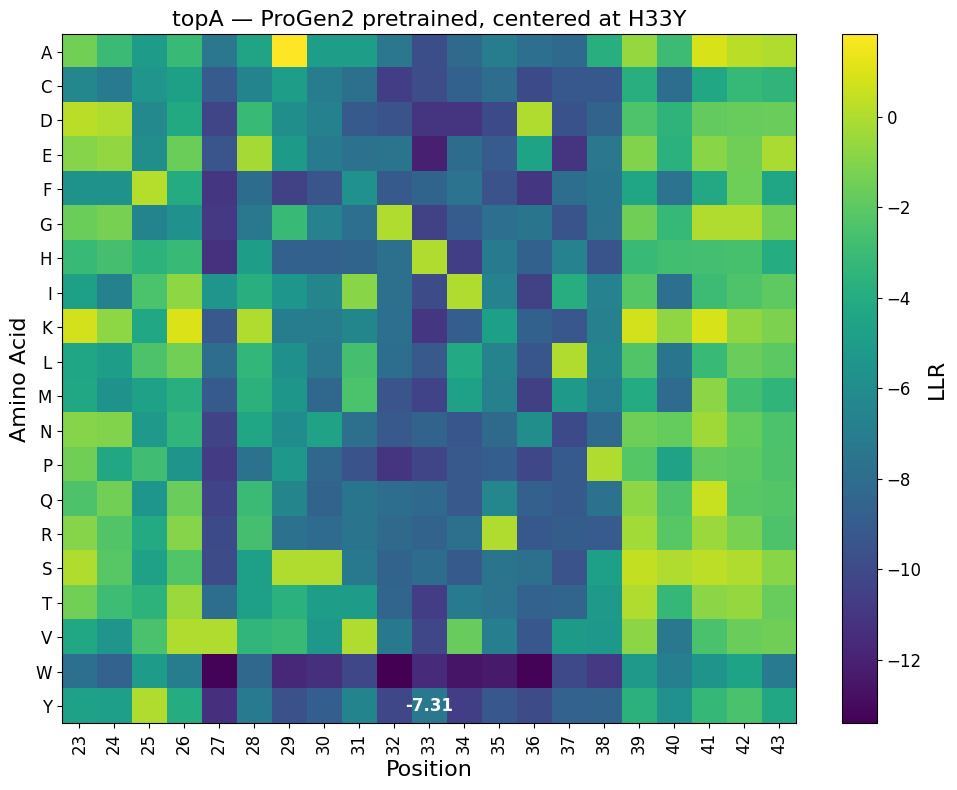

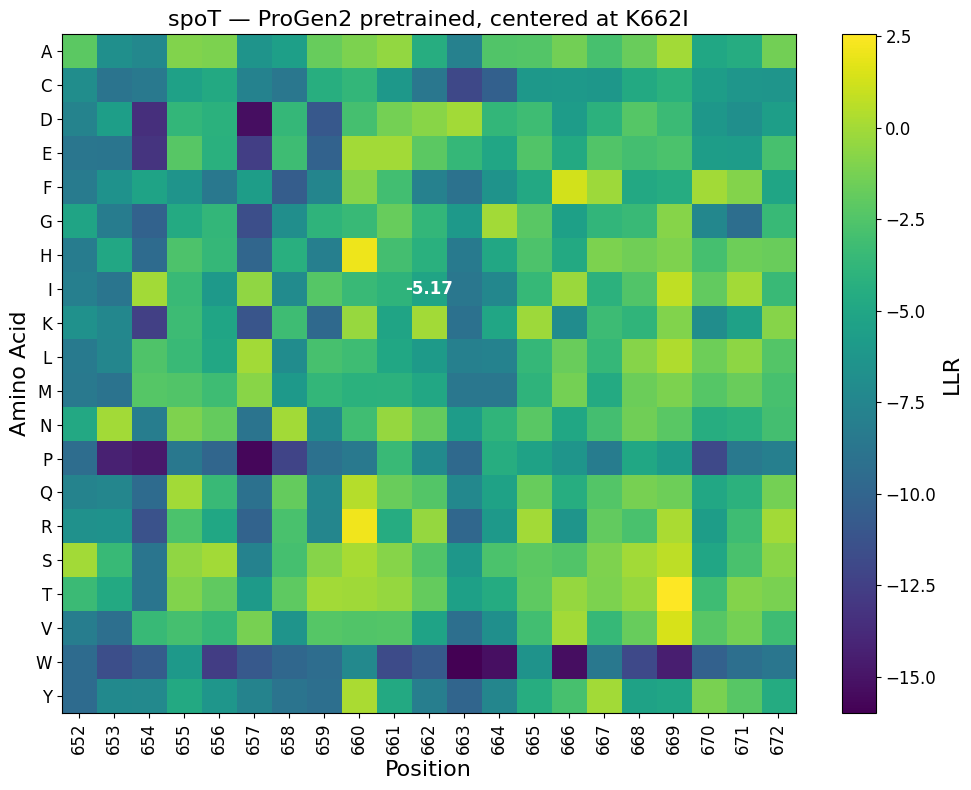

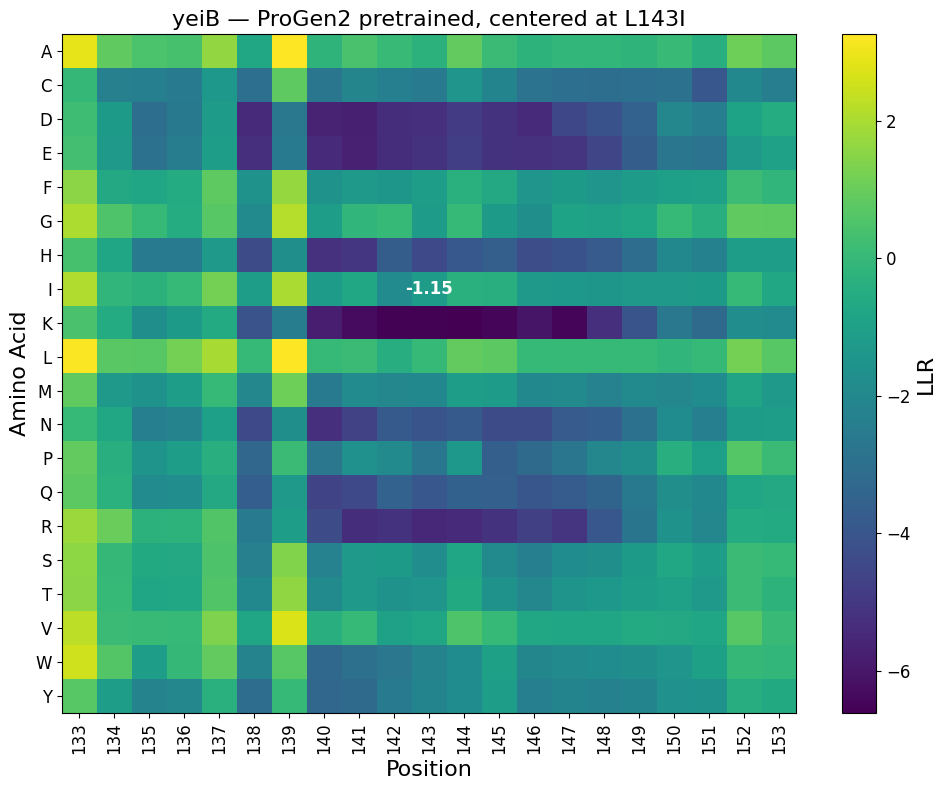

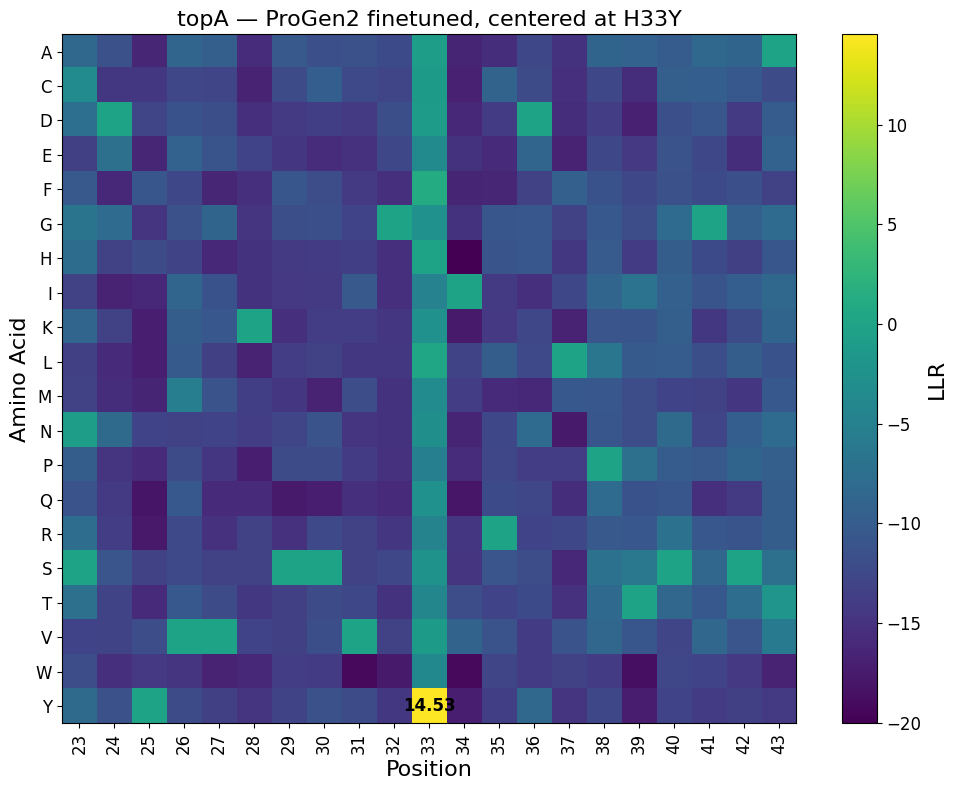

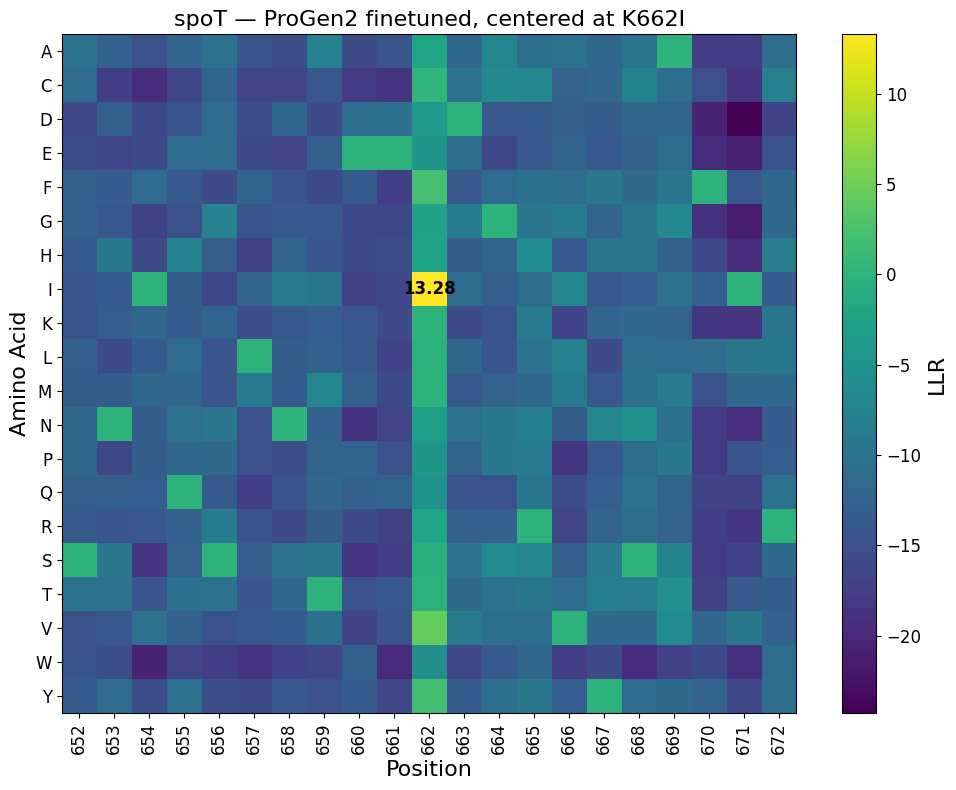

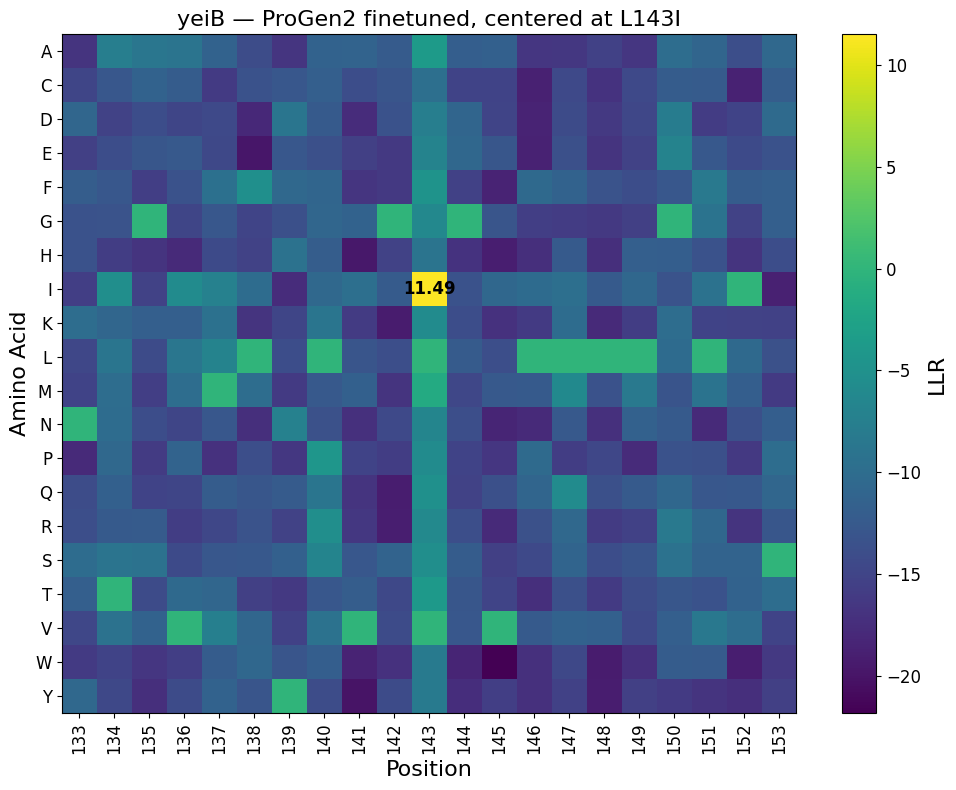

In [15]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_centered_heatmap(csv_file, mutated_pos, mutated_residue, window_size=5, figsize=(8, 6), cmap="viridis", title=None, dynamic_text_color=False):
    """
    Load LLR data from CSV, center the heatmap around mutated_pos ± window_size,
    annotate only the cell corresponding to the mutation, and adjust text color
    for dark backgrounds if dynamic_text_color is True.
    """
    # Load & sort
    df = pd.read_csv(csv_file, index_col=0)
    df.columns = df.columns.astype(int)
    df = df.sort_index(axis=1)
    
    # Center window
    cols = df.columns.tolist()
    if mutated_pos not in cols:
        raise ValueError(f"{mutated_pos} not in {csv_file} columns.")
    idx = cols.index(mutated_pos)
    start = max(0, idx - window_size)
    end = min(len(cols), idx + window_size + 1)
    sub_df = df.iloc[:, start:end]
    
    # Locate mutation cell
    col_labels = sub_df.columns.tolist()
    row_labels = sub_df.index.tolist()
    j = col_labels.index(mutated_pos)
    if mutated_residue not in row_labels:
        raise ValueError(f"Residue {mutated_residue} not in rows.")
    i = row_labels.index(mutated_residue)
    val = sub_df.iloc[i, j]
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(sub_df.values, aspect='auto', cmap=cmap)
    
    # Determine text color if needed
    text_color = 'black'
    if dynamic_text_color:
        norm = Normalize(vmin=np.nanmin(sub_df.values), vmax=np.nanmax(sub_df.values))
        rgba = plt.get_cmap(cmap)(norm(val))
        lum = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
        if lum < 0.5:
            text_color = 'white'
    
    # Annotate mutation cell
    ax.text(j, i, f"{val:.2f}", ha='center', va='center',
            fontsize=12, fontweight='bold', color=text_color)
    
    # Labels
    ax.set_xticks(range(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=90, fontsize=12)
    ax.set_yticks(range(len(row_labels)))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.set_xlabel("Position", fontsize=16)
    ax.set_ylabel("Amino Acid", fontsize=16)
    ax.set_title(title, fontsize=16)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label("LLR", fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Map genes to their mutation strings
gene_mutation = {"topA":"H33Y", "spoT":"K662I", "yeiB":"L143I"}

# Loop through each full-sequence CSV and plot
for csv_file in glob.glob("*_full_sequence.csv"):
    # filename format: gene_model_status_full_sequence.csv
    parts = csv_file.replace(".csv", "").split("_")
    gene, model_family, status = parts[0], parts[1], parts[2]
    
    mut = gene_mutation.get(gene)
    if not mut:
        continue
    mutated_pos = int(mut[1:-1])
    mutated_residue = mut[-1]
    
    # Build title with model info
    model_type = "ESM‑2" if "esm" in model_family.lower() else "ProGen2"
    status_text = "pretrained" if "pretrained" in status.lower() else "finetuned"
    title = f"{gene} — {model_type} {status_text}, centered at {mut}"
    
    # Only apply dynamic text color for pretrained plots
    dynamic_color = (status_text == "pretrained")
    
    # Plot centered heatmap
    plot_centered_heatmap(
        csv_file,
        mutated_pos=mutated_pos,
        mutated_residue=mutated_residue,
        window_size=10,
        figsize=(10, 8),
        cmap="viridis",
        title=title,
        dynamic_text_color=dynamic_color
    )


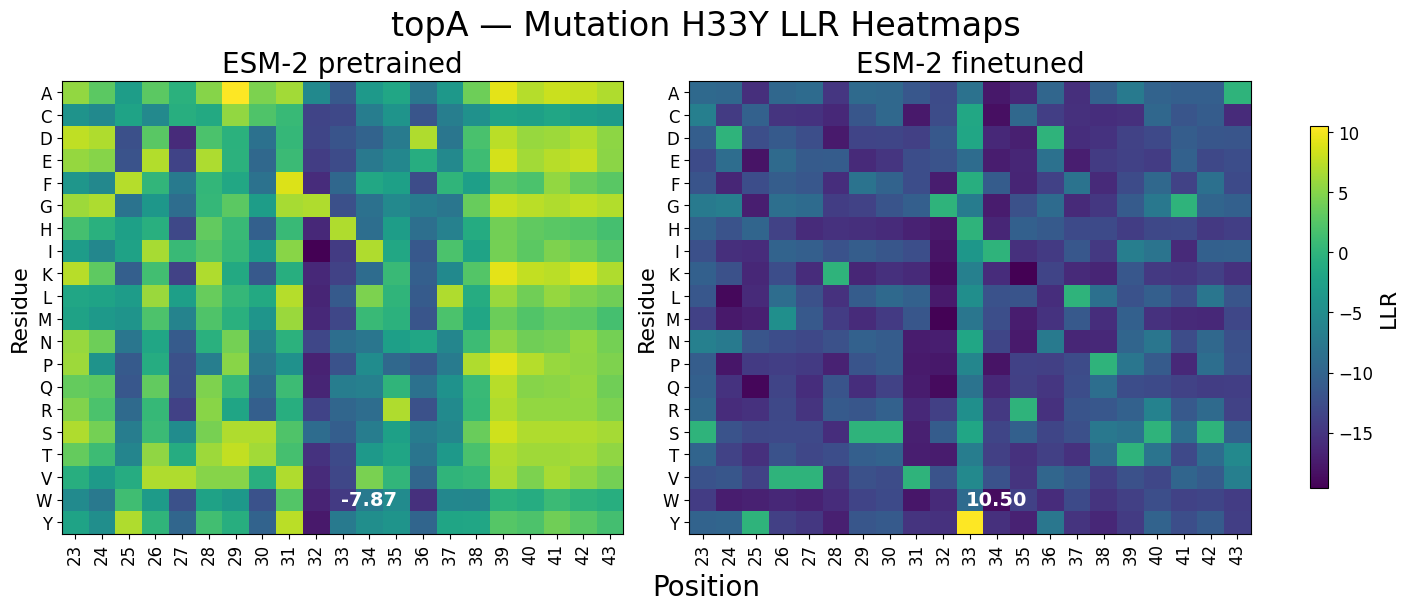

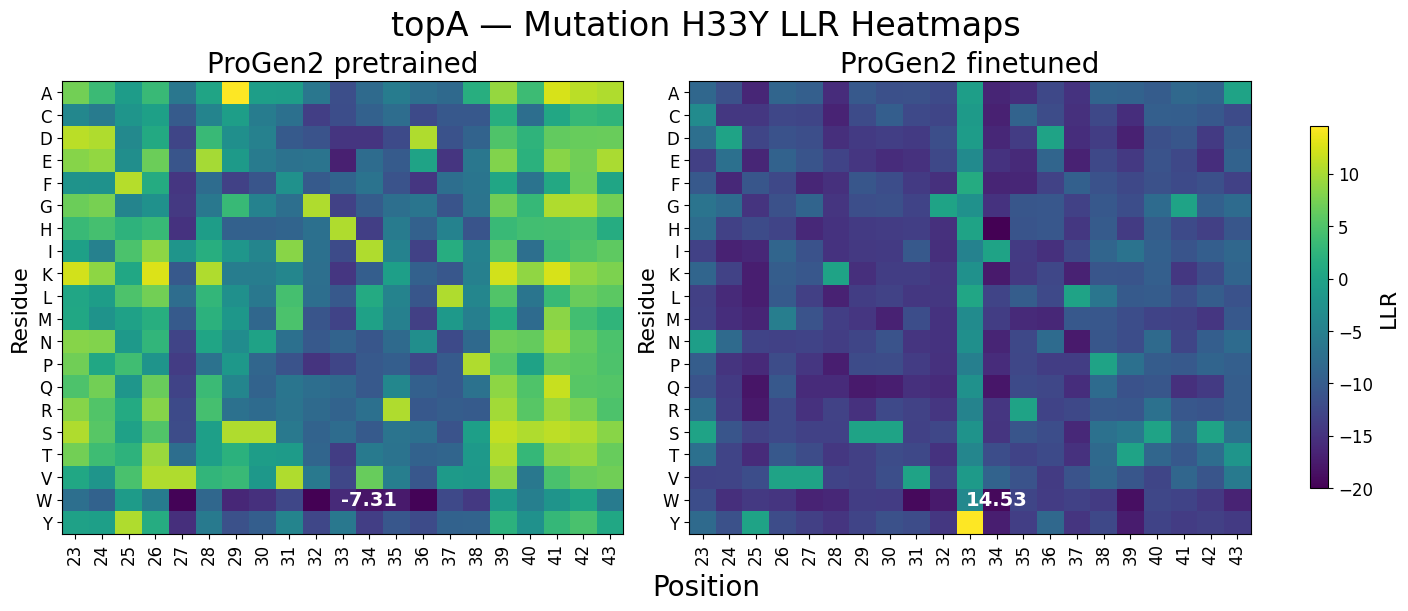

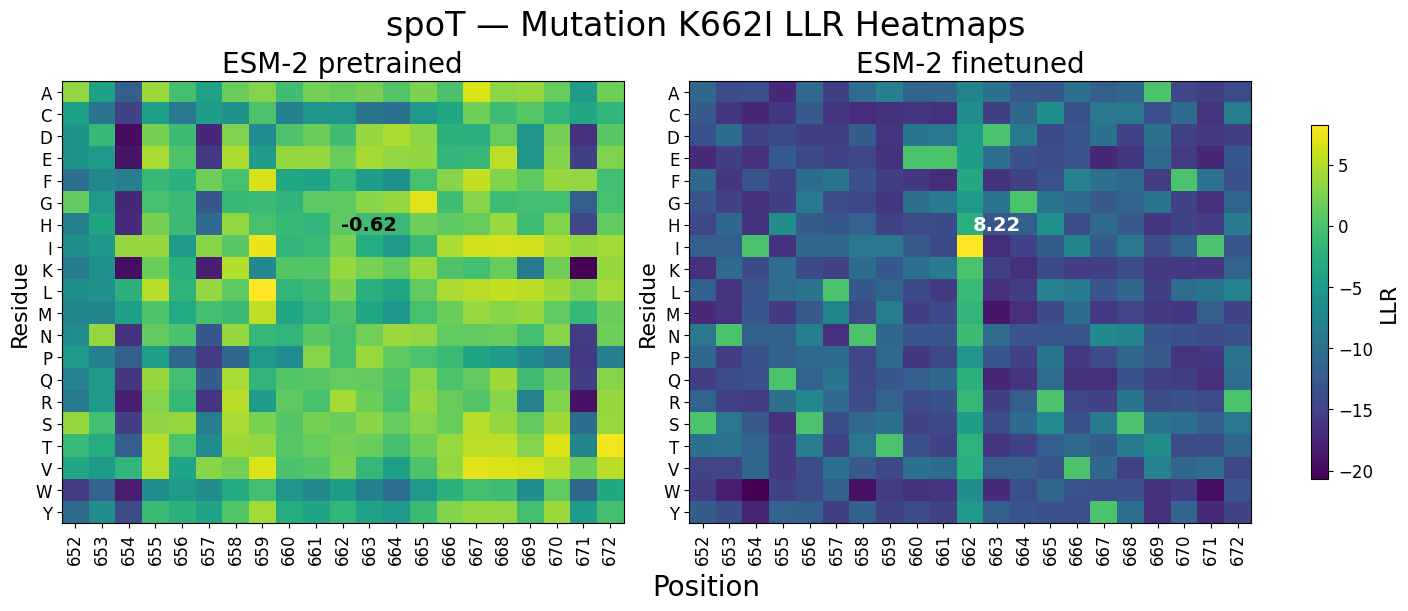

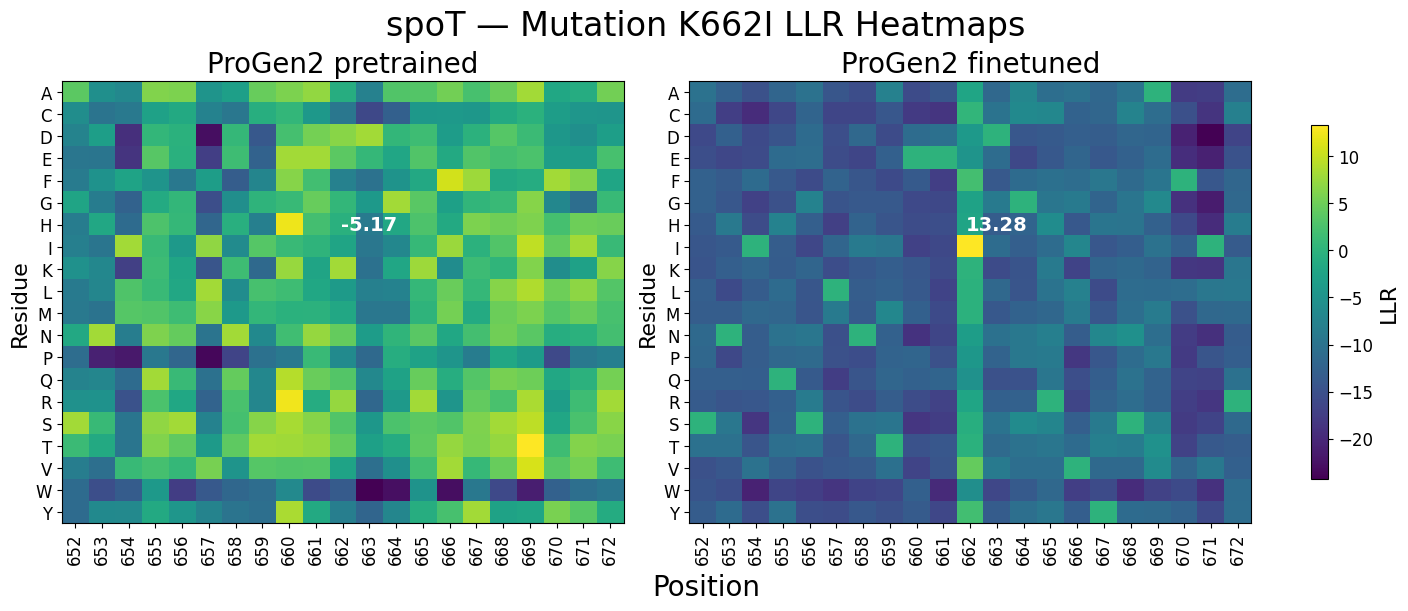

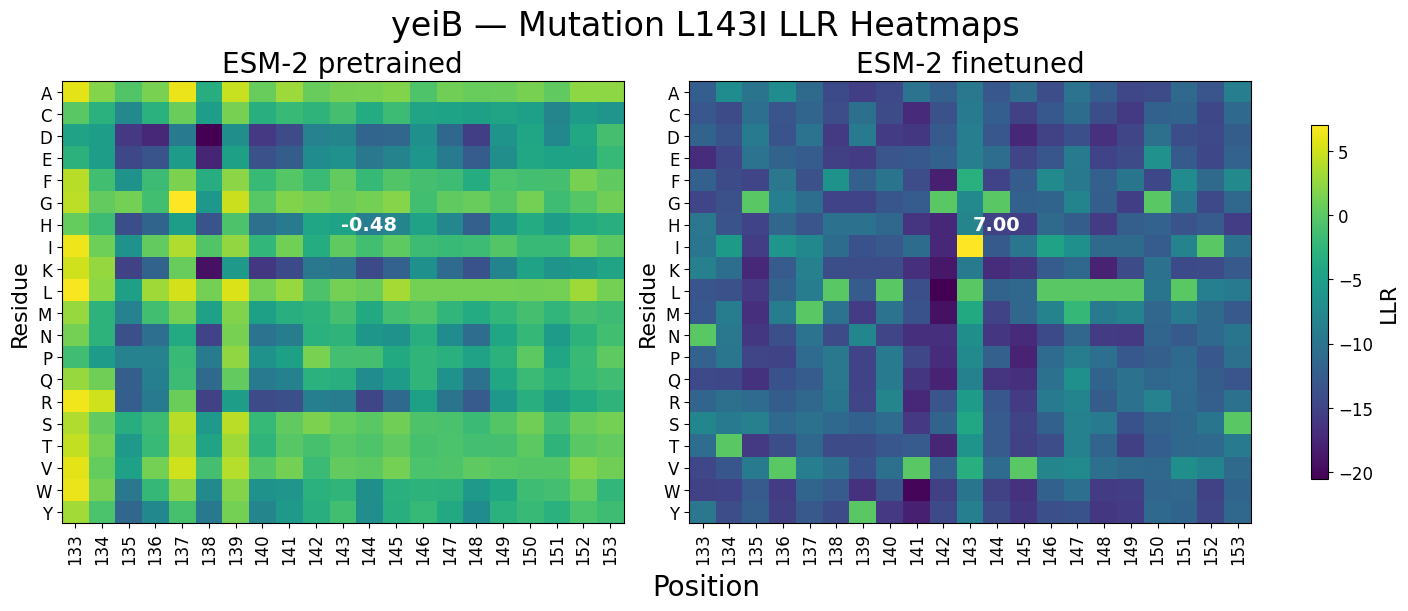

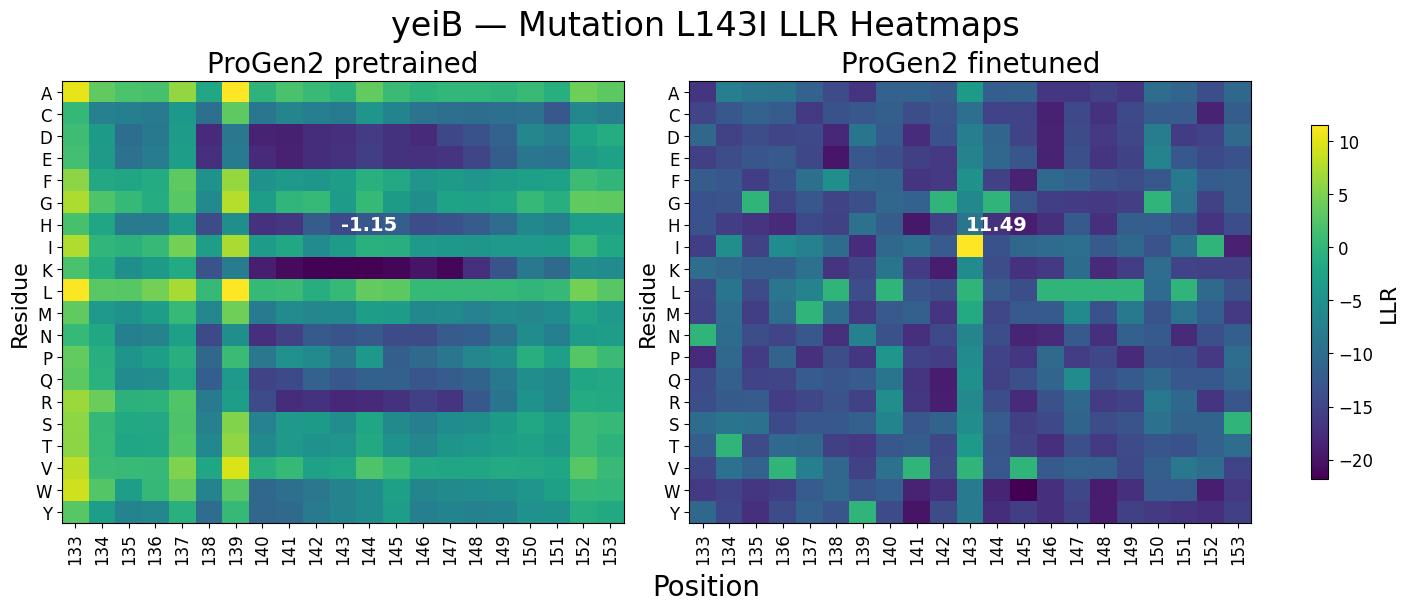

In [43]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Mapping from gene to its mutation string
gene_mutation = {"topA": "H33Y", "spoT": "K662I", "yeiB": "L143I"}

def draw_centered_heatmap_on_axis(
    ax,
    csv_file,
    mutated_pos,
    mutated_residue,
    window_size=10,
    cmap="viridis",
    offset_x=0.0,
    offset_y=0.0
):
    """
    Draws a centered heatmap on the given axis, annotating the mutation cell
    with its value and offset from the neighboring cell.
    Text color is white if the background at the annotation location is dark.
    Adds a y-axis label 'Residue'.
    """
    # Load & prepare DataFrame
    df = pd.read_csv(csv_file, index_col=0)
    df.columns = df.columns.astype(int)
    df = df.sort_index(axis=1)

    # Center window
    cols = df.columns.tolist()
    idx = cols.index(mutated_pos)
    start = max(0, idx - window_size)
    end = min(len(cols), idx + window_size + 1)
    sub_df = df.iloc[:, start:end]

    values = sub_df.values
    im = ax.imshow(values, aspect='auto', cmap=cmap)

    # Locate mutation cell indices
    row_labels = sub_df.index.tolist()
    col_labels = sub_df.columns.tolist()
    i = row_labels.index(mutated_residue)
    j = col_labels.index(mutated_pos)
    cell_val = values[i, j]

    # Neighbor for Δ calculation
    if j > 0:
        neighbor_val = values[i, j-1]
    else:
        neighbor_val = values[i, j+1] if j < values.shape[1]-1 else 0.0
    delta = cell_val - neighbor_val

    # Determine annotation position and color
    annot_i = i + offset_y
    annot_j = j + offset_x
    samp_i = int(np.clip(round(annot_i), 0, values.shape[0]-1))
    samp_j = int(np.clip(round(annot_j), 0, values.shape[1]-1))
    samp_val = values[samp_i, samp_j]
    norm = Normalize(vmin=np.nanmin(values), vmax=np.nanmax(values))
    rgba = plt.get_cmap(cmap)(norm(samp_val))
    lum = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
    text_color = 'white' if lum < 0.5 else 'black'

    # Annotate mutation cell
    ax.text(
        j + offset_x,
        i + offset_y,
        f"{cell_val:.2f}",
        ha='center', va='center',
        fontsize=14, fontweight='bold',
        color=text_color
    )

    # Axis formatting
    ax.set_xticks(range(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=90, fontsize=12)
    ax.set_yticks(range(len(row_labels)))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.set_ylabel("Residue", fontsize=16)

    return im

# Subplot loop
for gene, mut in gene_mutation.items():
    pos = int(mut[1:-1])
    res = mut[-1]
    for family in ("esm", "progen"):
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
        model_type = "ESM‑2" if family=="esm" else "ProGen2"
        for ax, status in zip(axes, ("pretrained","finetuned")):
            filename = f"{gene}_{family}_{status}_full_sequence.csv"
            im = draw_centered_heatmap_on_axis(
                ax, filename,
                mutated_pos=pos,
                mutated_residue=res,
                window_size=10,
                cmap="viridis",
                offset_x=1,
                offset_y=-1
            )
            ax.set_title(f"{model_type} {status}", fontsize=20)
        # Global x-axis label
        fig.supxlabel("Position", fontsize=20)
        plt.suptitle(f"{gene} — Mutation {mut} LLR Heatmaps", fontsize=24)
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label("LLR", fontsize=16)
        plt.show()


In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Mapping from gene to its mutation string
gene_mutation = {"topA": "H33Y", "spoT": "K662I", "yeiB": "L143I"}
families = ["esm", "progen"]

def annotate_heatmap(ax, df, mutated_pos, mutated_residue,
                     window_size=10, cmap="viridis", offset_x=0.0, offset_y=0.0):
    # Center window
    cols = df.columns.tolist()
    idx = cols.index(mutated_pos)
    start = max(0, idx - window_size)
    end = min(len(cols), idx + window_size + 1)
    sub_df = df.iloc[:, start:end]
    values = sub_df.values
    im = ax.imshow(values, aspect='auto', cmap=cmap)
    
    # Locate mutation cell
    row_labels = sub_df.index.tolist()
    col_labels = sub_df.columns.tolist()
    i = row_labels.index(mutated_residue)
    j = col_labels.index(mutated_pos)
    cell_val = values[i, j]
    
    # Neighbor delta
    neighbor_val = values[i, j-1] if j>0 else (values[i, j+1] if j < values.shape[1]-1 else 0.0)
    delta = cell_val - neighbor_val
    
    # Sample background at offset annotation
    annot_i = i + offset_y
    annot_j = j + offset_x
    samp_i = int(np.clip(round(annot_i), 0, values.shape[0]-1))
    samp_j = int(np.clip(round(annot_j), 0, values.shape[1]-1))
    samp_val = values[samp_i, samp_j]
    norm = Normalize(vmin=np.nanmin(values), vmax=np.nanmax(values))
    rgba = plt.get_cmap(cmap)(norm(samp_val))
    lum = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
    text_color = 'white' if lum < 0.5 else 'black'
    
    # Annotate cell
    ax.text(j + offset_x, i + offset_y,
            f"{cell_val:.2f}",
            ha='center', va='center',
            fontsize=16, fontweight='bold',
            color=text_color)
    
    # Ticks
    ax.set_xticks(range(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=90, fontsize=10)
    ax.set_yticks(range(len(row_labels)))
    ax.set_yticklabels(row_labels, fontsize=10)
    return im

# Create and save subplots for each gene & family
for gene, mut in gene_mutation.items():
    pos = int(mut[1:-1])
    res = mut[-1]
    for fam in families:
        pre_file = f"{gene}_{fam}_pretrained_full_sequence.csv"
        fin_file = f"{gene}_{fam}_finetuned_full_sequence.csv"
        if not (os.path.exists(pre_file) and os.path.exists(fin_file)):
            print(f"Skipping {gene} {fam}: missing files.")
            continue
        
        # Load DataFrames
        df_pre = pd.read_csv(pre_file, index_col=0)
        df_pre.columns = df_pre.columns.astype(int)
        df_pre = df_pre.sort_index(axis=1)
        
        df_fin = pd.read_csv(fin_file, index_col=0)
        df_fin.columns = df_fin.columns.astype(int)
        df_fin = df_fin.sort_index(axis=1)
        
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
        model_type = "ESM‑2" if fam=="esm" else "ProGen2"
        
        # Pretrained
        im = annotate_heatmap(
            axes[0], df_pre, pos, res,
            window_size=10, cmap="viridis",
            offset_x=1, offset_y=-1
        )
        axes[0].set_title(f"{model_type} pretrained", fontsize=20)
        axes[0].set_xlabel("Position", fontsize=20)
        axes[0].set_ylabel("Residue", fontsize=20)
        
        # Finetuned
        annotate_heatmap(
            axes[1], df_fin, pos, res,
            window_size=10, cmap="viridis",
            offset_x=1, offset_y=-1
        )
        axes[1].set_title(f"{model_type} finetuned", fontsize=20)
        
        # Supertitle and colorbar
        plt.suptitle(f"{gene} Mutation {mut} LLR Heatmaps", fontsize=24)
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label("LLR", fontsize=20)
        
        # Save figure
        out_fname = f"{gene}_{fam}_mutation_{mut}_comparison.png"
        fig.savefig(out_fname, dpi=300)
        print(f"Saved subplot to {out_fname}")
        plt.close(fig)


Saved subplot to topA_esm_mutation_H33Y_comparison.png
Saved subplot to topA_progen_mutation_H33Y_comparison.png
Saved subplot to spoT_esm_mutation_K662I_comparison.png
Saved subplot to spoT_progen_mutation_K662I_comparison.png
Saved subplot to yeiB_esm_mutation_L143I_comparison.png
Saved subplot to yeiB_progen_mutation_L143I_comparison.png


In [56]:
import glob
import pandas as pd
import numpy as np

# Your mapping of genes to mutations
gene_mutation = {"topA": "H33Y", "spoT": "K662I", "yeiB": "L143I"}

records = []
for path in glob.glob("*_full_sequence.csv"):
    # Expect filenames like "topA_esm_pretrained_full_sequence.csv"
    parts = path.replace(".csv", "").split("_")
    if len(parts) < 4:
        continue
    gene, family, status = parts[0], parts[1], parts[2]
    mut = gene_mutation.get(gene)
    if mut is None:
        continue

    # Load the CSV
    df = pd.read_csv(path, index_col=0)
    # Ensure integer columns and sorted
    df.columns = df.columns.astype(int)
    df = df.sort_index(axis=1)

    pos = int(mut[1:-1])
    res = mut[-1]
    # The LLR at the mutation
    cell_val = df.at[res, pos]

    # The neighbor (left if available, else right)
    cols = list(df.columns)
    j = cols.index(pos)
    if j > 0:
        neighbor_val = df.iloc[df.index.get_loc(res), j - 1]
    else:
        neighbor_val = df.iloc[df.index.get_loc(res), j + 1]
    delta = cell_val - neighbor_val

    annotated = f"{cell_val:.2f} / Δ{delta:.2f}"
    model_label = f"{family.upper()} {status}"

    records.append({
        "Gene": gene,
        "Mutation": mut,
        "Model": model_label,
        "Annotated Text": annotated
    })

# Build DataFrame and print markdown table
table = pd.DataFrame(records, columns=["Gene", "Mutation", "Model", "Annotated Text"])
print(table.to_markdown(index=False))


| Gene   | Mutation   | Model             | Annotated Text   |
|:-------|:-----------|:------------------|:-----------------|
| topA   | H33Y       | ESM pretrained    | -7.87 / Δ5.72    |
| spoT   | K662I      | ESM pretrained    | -0.62 / Δ1.67    |
| yeiB   | L143I      | ESM pretrained    | -0.48 / Δ1.71    |
| topA   | H33Y       | ESM finetuned     | 10.50 / Δ25.90   |
| spoT   | K662I      | ESM finetuned     | 8.22 / Δ22.45    |
| yeiB   | L143I      | ESM finetuned     | 7.00 / Δ24.42    |
| topA   | H33Y       | PROGEN pretrained | -7.31 / Δ2.88    |
| spoT   | K662I      | PROGEN pretrained | -5.17 / Δ-1.23   |
| yeiB   | L143I      | PROGEN pretrained | -1.15 / Δ0.69    |
| topA   | H33Y       | PROGEN finetuned  | 14.53 / Δ29.01   |
| spoT   | K662I      | PROGEN finetuned  | 13.28 / Δ29.40   |
| yeiB   | L143I      | PROGEN finetuned  | 11.49 / Δ23.68   |
